In [1]:
import galprime as grp

from photutils import morphology
from photutils.isophote import EllipseGeometry, Ellipse
from photutils.aperture import EllipticalAperture

from matplotlib import pyplot as plt
import numpy as np

from astropy import units as u

import warnings
warnings.filterwarnings("ignore")

In [2]:
def estimate_morphology(cutout, mask=None, mult=1.):
    """
    Estimate the morphology of a galaxy.
    """
    try:
        morph_cat = morphology.data_properties(cutout)
        pos = (morph_cat.xcentroid, morph_cat.ycentroid)
        a = morph_cat.semimajor_sigma.value * mult
        b = morph_cat.semiminor_sigma.value * mult
        theta = morph_cat.orientation
        return EllipseGeometry(x0=pos[0], y0=pos[1],  sma=a, eps=1 - b/a, pa=theta.value)
    except Exception as e:
        return None


def convert_ellipsegeometry_to_ellipticalaperture(eg):
    b = eg.sma * (1 - eg.eps)
    return EllipticalAperture(positions=(eg.x0, eg.y0), a=eg.sma, b=b, theta=eg.pa)

10
10


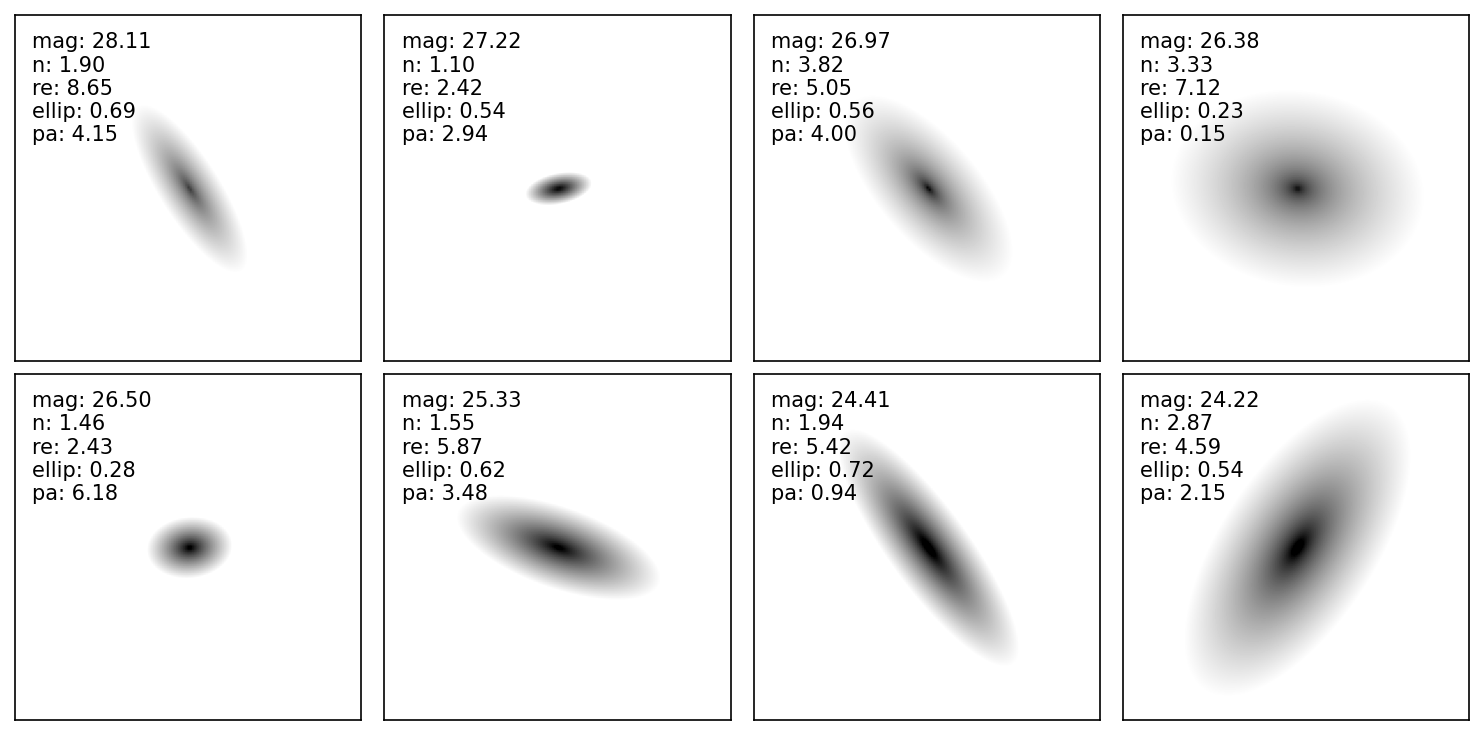

In [3]:
models = grp.gen_sersic_models(10, width=(151, 151))

print(len(models.cutout_data))
models.show_cutouts(method="log", vmin=-5, vmax=-1, ncols=4, model_data=models.cutout_data)




In [6]:

class PoorFitException(Exception):
    pass


def isophote_fitting(data, config):
    
    fail_count, max_fails = 0, 100
    linear = config.get("EXTRACTION", {}).get("LINEAR", False)
    step = config.get("EXTRACTION", {}).get("STEP", 0.1)
    fix_center = config.get("EXTRACTION", {}).get("FIX_CENTER", False)
    maxit = config.get("EXTRACTION", {}).get("MAXIT", 100)

    cutout_halfwidth = max((data.shape[0] // 2, data.shape[1] // 2))
    maxrit = config.get("EXTRACTION", {}).get("MAXRIT", cutout_halfwidth / 3)
   

    def attempt_fit(geo):
        # Attempt to fit the ellipse with the given imput geometry
        flux = Ellipse(data, geo)
        try:
            fitting_list = flux.fit_image(maxit=maxit, maxsma=cutout_halfwidth, step=step, linear=linear,
                                        maxrit=maxrit, fix_center=fix_center)
            if len(fitting_list) > 0:
                return fitting_list
        except Exception as e:
            raise PoorFitException(f"Bad fit! {type(e)} {e}")
    
    # First try to get an extraction by estimating the morphology
    try:
        geo = estimate_morphology(data)
        fitting_list = attempt_fit(geo)
        if fitting_list is not None and len(fitting_list) > 0:
            return {"ISOLIST": fitting_list, "FIT_METHOD": 0, "GEO": geo}
    except Exception as e:
        pass

    # If that fails, try a range of possible ellipses
    for sma in np.arange(10, cutout_halfwidth, 10):
        for eps in [0.1, 0.5, 0.9]:
            for pa in np.deg2rad([0, 45, 90, 135]):
                geo = EllipseGeometry(x0=data.shape[1] // 2, y0=data.shape[0] // 2, sma=sma, eps=eps, pa=pa)
                try:
                    fitting_list = attempt_fit(geo)
                    if fitting_list is not None and len(fitting_list) > 0:
                        return {"ISOLIST": fitting_list, "FIT_METHOD": 1, "GEO": geo}
                except Exception as e:
                    continue

    
    return None
            


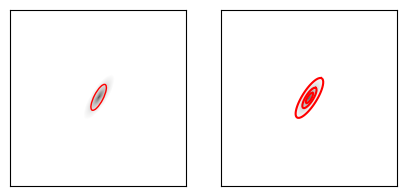

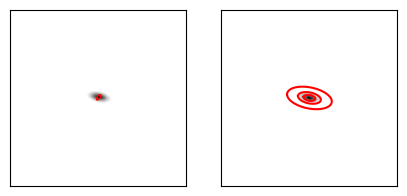

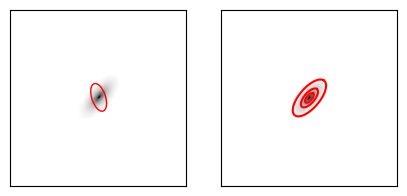

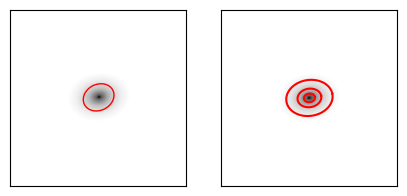

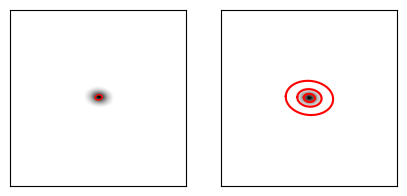

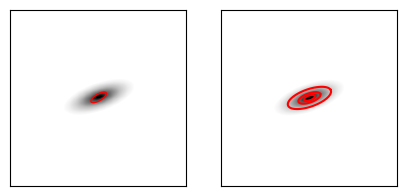

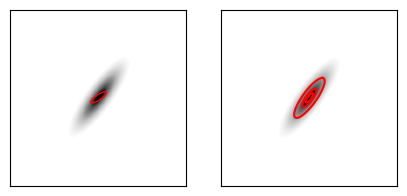

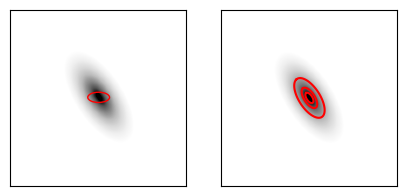

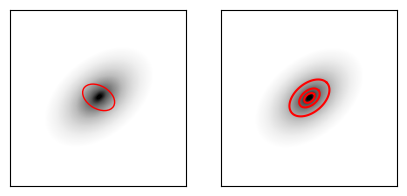

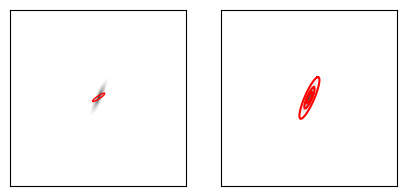

In [8]:
for cutout in models.cutouts:
    morph = estimate_morphology(cutout)
    geo = convert_ellipsegeometry_to_ellipticalaperture(morph)

    fig, ax = plt.subplots(1, 2, figsize=(5, 3))
    
    for axis in ax:
        axis.imshow(np.log10(cutout), cmap='Greys', origin='lower', vmin=-4, vmax=-1)
        axis.set(xticks=[], yticks=[])
    geo.plot(ax=ax[0], color='red')

    fit_results = isophote_fitting(cutout, grp.default_config())
    if fit_results is not None:
        isolist = fit_results.get("ISOLIST")
        geo = fit_results.get("GEO")
        if isolist is not None:
            for r in [5, 10, 20]:
                iso = isolist.get_closest(r)
                x,y = iso.sampled_coordinates()
                ax[1].plot(x, y, color='red')
        ax[1].set(xlim=(0, cutout.shape[1]), ylim=(0, cutout.shape[0]))
        plt.show()

In [9]:
# Good, so that is working now let's try masked data

